## 0. Goal
Run VAE first to reduce spectrogram dimensions from 128*128 to 32 latent features. Then run UMAP and HDBSCAN. <br>
Use Goffinet spectrogramming and VAE network. <br>
Differ from v1: use the shuffling method used by Goffinet for negative control

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import calinski_harabasz_score

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import hopkins2
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)
importlib.reload(hopkins2)

<module 'hopkins2' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/hopkins2.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8]]
# what syllable to analyze
syl = ['v']
sylStr = ''.join(syl)
# the default color list
col_list = ['#e41a1c','#a65628','#4daf4a','#984ea3','#ff7f00','#f781bf','#377eb8','#737373']
# what input dataset to use: real and matched shuffle
run_names = ['spec_goffinet_nn_256_176']
# size of the spectrogram windows
X_SHAPE = [128, 128]

In [5]:
# paramteres for UMAP and HDBSCAN
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'euclidean'}
param_hdbscan = {'min_cluster_size_frac':0.05, 'min_samples': 20}

## 2. Loop through birds: VAE -> UMAP -> HDBSCAN

In [13]:
# save metrics in a master dataframe
metrics = pd.DataFrame()

Processing for pair4RigACU68 spec_goffinet_nn_256_176...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigACU68/UMAPonVAE1/v/spec_goffinet_nn_256_176
(36359, 128, 128) (36359, 7)
Training: epochs 0 to 50
Training set: 36359
Test set: 36359


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Average loss: 6138.3496
Epoch: 1 Average loss: 969.5624
Epoch: 2 Average loss: 774.7415
Epoch: 3 Average loss: 671.6697
Epoch: 4 Average loss: 607.1512
Epoch: 5 Average loss: 563.9089
Epoch: 6 Average loss: 523.5275
Epoch: 7 Average loss: 493.0589
Epoch: 8 Average loss: 478.6274
Epoch: 9 Average loss: 465.3738
Epoch: 10 Average loss: 451.0897
Epoch: 11 Average loss: 443.6347
Epoch: 12 Average loss: 434.9340
Epoch: 13 Average loss: 427.6787
Epoch: 14 Average loss: 422.7805
Epoch: 15 Average loss: 414.5592
Epoch: 16 Average loss: 409.7055
Epoch: 17 Average loss: 404.4819
Epoch: 18 Average loss: 399.2155
Epoch: 19 Average loss: 393.5129
Epoch: 20 Average loss: 390.6682
Epoch: 21 Average loss: 383.0037
Epoch: 22 Average loss: 377.6821
Epoch: 23 Average loss: 376.0754
Epoch: 24 Average loss: 371.6905
Epoch: 25 Average loss: 365.0858
Epoch: 26 Average loss: 363.9939
Epoch: 27 Average loss: 358.2145
Epoch: 28 Average loss: 354.1730
Epoch: 29 Average loss: 350.2870
Epoch: 30 Average l

569it [00:41, 13.77it/s]


(36359, 32)
{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jun  9 12:16:37 2025 Construct fuzzy simplicial set
Mon Jun  9 12:16:37 2025 Finding Nearest Neighbors
Mon Jun  9 12:16:37 2025 Building RP forest with 15 trees
Mon Jun  9 12:16:37 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 12:16:38 2025 Finished Nearest Neighbor Search
Mon Jun  9 12:16:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 12:16:54 2025 Finished embedding
The fraction that are not clustered: 0.1887
Total number of clusters: 6
Hopkins metric in UMAP: 0.9838
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.3620
HDBSCAN Silhouette score in VAE: 0.0134
Calinski–Harabasz index in UMAP: 18939.5378
Calinski–Harabasz index in VAE: 1498.1977
{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jun  9 12:17:24 2025 Construct fuzzy simplicial set
Mon Jun  9 12:17:24 2025 Finding Nearest Neighbors
Mon Jun  9 12:17:24 2025 Building RP forest with 15 trees
Mon Jun  9 12:17:24 2025 NN descen

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 12:17:26 2025 Finished Nearest Neighbor Search
Mon Jun  9 12:17:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 12:17:42 2025 Finished embedding
The fraction that are not clustered: 0.5328
Total number of clusters: 3
Hopkins metric in UMAP: 0.8710
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: -0.0713
HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 3144.4542
Calinski–Harabasz index in VAE: 1.3119
Processing for pair4RigBCU53 spec_goffinet_nn_256_176...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigBCU53/UMAPonVAE1/v/spec_goffinet_nn_256_176
(16194, 128, 128) (16194, 7)
Training: epochs 0 to 50
Training set: 16194
Test set: 16194


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Average loss: 8637.4294
Epoch: 1 Average loss: 939.5700
Epoch: 2 Average loss: 694.2063
Epoch: 3 Average loss: 567.3398
Epoch: 4 Average loss: 499.3656
Epoch: 5 Average loss: 455.6576
Epoch: 6 Average loss: 418.2875
Epoch: 7 Average loss: 393.1635
Epoch: 8 Average loss: 378.0111
Epoch: 9 Average loss: 362.8206
Epoch: 10 Average loss: 348.2644
Epoch: 11 Average loss: 338.3266
Epoch: 12 Average loss: 327.7765
Epoch: 13 Average loss: 319.5313
Epoch: 14 Average loss: 310.4244
Epoch: 15 Average loss: 303.1356
Epoch: 16 Average loss: 297.9234
Epoch: 17 Average loss: 290.5037
Epoch: 18 Average loss: 289.2892
Epoch: 19 Average loss: 281.0698
Epoch: 20 Average loss: 277.0843
Epoch: 21 Average loss: 271.6528
Epoch: 22 Average loss: 267.2450
Epoch: 23 Average loss: 264.3862
Epoch: 24 Average loss: 263.9527
Epoch: 25 Average loss: 257.8015
Epoch: 26 Average loss: 255.1951
Epoch: 27 Average loss: 251.6803
Epoch: 28 Average loss: 252.0949
Epoch: 29 Average loss: 248.8138
Epoch: 30 Average l

254it [00:18, 13.70it/s]


(16194, 32)
{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jun  9 12:24:50 2025 Construct fuzzy simplicial set
Mon Jun  9 12:24:50 2025 Finding Nearest Neighbors
Mon Jun  9 12:24:50 2025 Building RP forest with 11 trees
Mon Jun  9 12:24:50 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 12:24:51 2025 Finished Nearest Neighbor Search
Mon Jun  9 12:24:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 12:24:58 2025 Finished embedding
The fraction that are not clustered: 0.2039
Total number of clusters: 5
Hopkins metric in UMAP: 0.9697
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.3090
HDBSCAN Silhouette score in VAE: -0.0018
Calinski–Harabasz index in UMAP: 7289.8932
Calinski–Harabasz index in VAE: 601.1207
{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jun  9 12:25:06 2025 Construct fuzzy simplicial set
Mon Jun  9 12:25:06 2025 Finding Nearest Neighbors
Mon Jun  9 12:25:06 2025 Building RP forest with 11 trees
Mon Jun  9 12:25:06 2025 NN descent

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 12:25:07 2025 Finished Nearest Neighbor Search
Mon Jun  9 12:25:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 12:25:14 2025 Finished embedding
The fraction that are not clustered: 0.6917
Total number of clusters: 3
Hopkins metric in UMAP: 0.8409
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: -0.1710
HDBSCAN Silhouette score in VAE: -0.0054
Calinski–Harabasz index in UMAP: 715.8640
Calinski–Harabasz index in VAE: 0.8337
Processing for pair2RigBCU25 spec_goffinet_nn_256_176...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/UMAPonVAE1/v/spec_goffinet_nn_256_176
(16452, 128, 128) (16452, 7)
Training: epochs 0 to 50
Training set: 16452
Test set: 16452


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Average loss: 9943.3636
Epoch: 1 Average loss: 1280.3123
Epoch: 2 Average loss: 940.4394
Epoch: 3 Average loss: 775.8455
Epoch: 4 Average loss: 728.9661
Epoch: 5 Average loss: 683.3749
Epoch: 6 Average loss: 639.9882
Epoch: 7 Average loss: 606.1838
Epoch: 8 Average loss: 593.8313
Epoch: 9 Average loss: 558.6431
Epoch: 10 Average loss: 544.4505
Epoch: 11 Average loss: 524.6711
Epoch: 12 Average loss: 512.8685
Epoch: 13 Average loss: 500.4372
Epoch: 14 Average loss: 495.5651
Epoch: 15 Average loss: 488.9844
Epoch: 16 Average loss: 477.5640
Epoch: 17 Average loss: 471.1135
Epoch: 18 Average loss: 462.0110
Epoch: 19 Average loss: 456.2801
Epoch: 20 Average loss: 448.9858
Epoch: 21 Average loss: 448.1696
Epoch: 22 Average loss: 439.6252
Epoch: 23 Average loss: 434.5098
Epoch: 24 Average loss: 434.2835
Epoch: 25 Average loss: 426.0876
Epoch: 26 Average loss: 421.2205
Epoch: 27 Average loss: 419.0094
Epoch: 28 Average loss: 415.3908
Epoch: 29 Average loss: 416.5407
Epoch: 30 Average 

258it [00:18, 13.76it/s]


(16452, 32)
{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jun  9 12:31:53 2025 Construct fuzzy simplicial set
Mon Jun  9 12:31:53 2025 Finding Nearest Neighbors
Mon Jun  9 12:31:53 2025 Building RP forest with 11 trees
Mon Jun  9 12:31:53 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 12:31:53 2025 Finished Nearest Neighbor Search
Mon Jun  9 12:31:54 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 12:32:00 2025 Finished embedding
The fraction that are not clustered: 0.0058
Total number of clusters: 3
Hopkins metric in UMAP: 0.9849
Hopkins metric in VAE: 0.8310
HDBSCAN Silhouette score in UMAP: 0.4503
HDBSCAN Silhouette score in VAE: 0.0325
Calinski–Harabasz index in UMAP: 14335.3560
Calinski–Harabasz index in VAE: 864.1092
{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jun  9 12:32:10 2025 Construct fuzzy simplicial set
Mon Jun  9 12:32:10 2025 Finding Nearest Neighbors
Mon Jun  9 12:32:10 2025 Building RP forest with 11 trees
Mon Jun  9 12:32:10 2025 NN descent

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 12:32:10 2025 Finished Nearest Neighbor Search
Mon Jun  9 12:32:10 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 12:32:18 2025 Finished embedding
The fraction that are not clustered: 0.5827
Total number of clusters: 2
Hopkins metric in UMAP: 0.8624
Hopkins metric in VAE: 0.8310
HDBSCAN Silhouette score in UMAP: -0.0771
HDBSCAN Silhouette score in VAE: -0.0004
Calinski–Harabasz index in UMAP: 800.7849
Calinski–Harabasz index in VAE: 0.9685


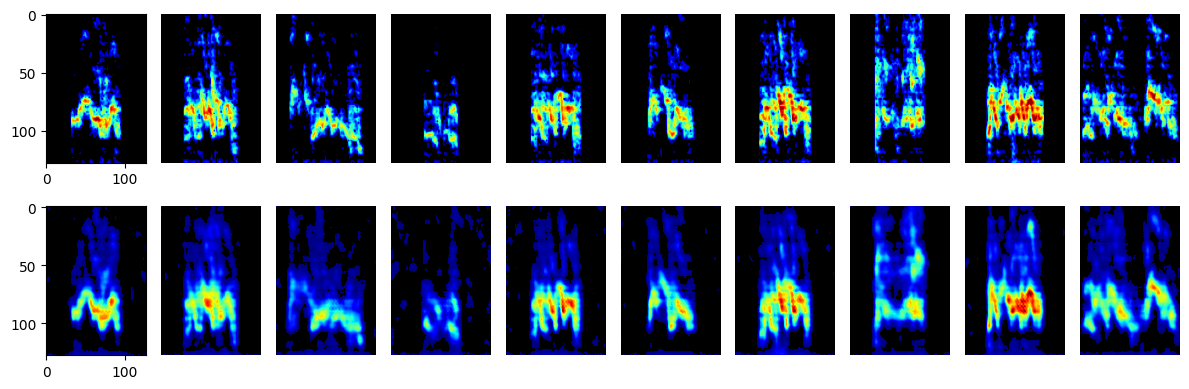

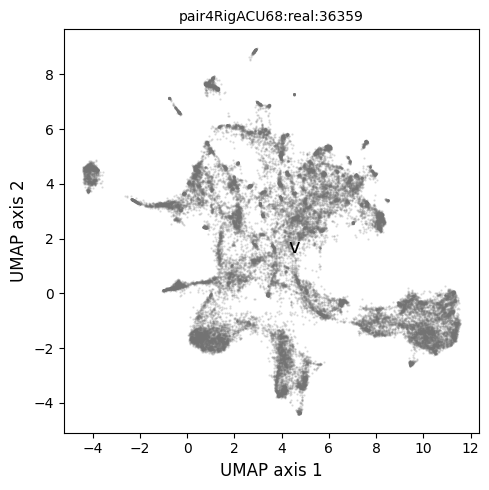

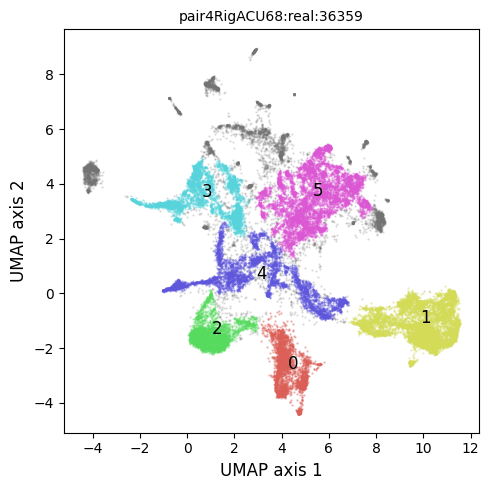

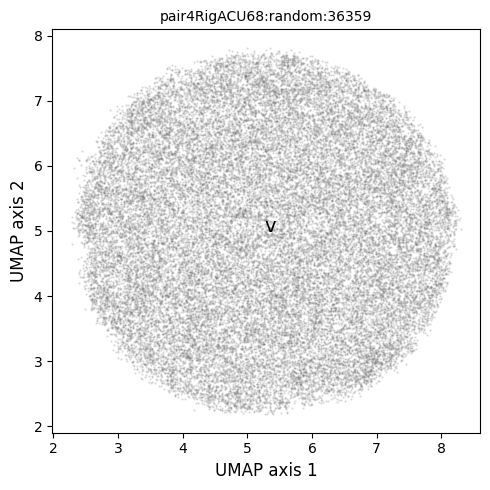

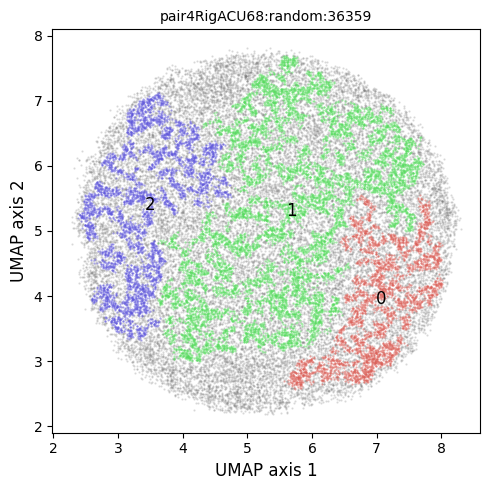

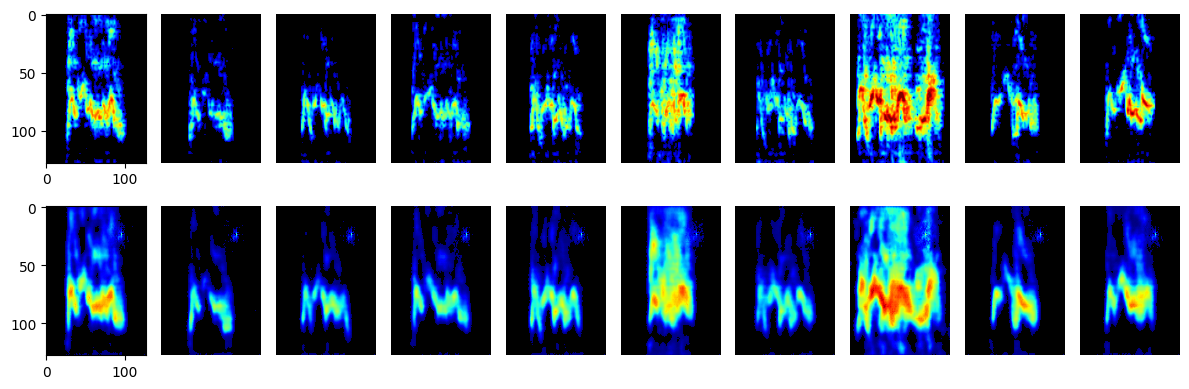

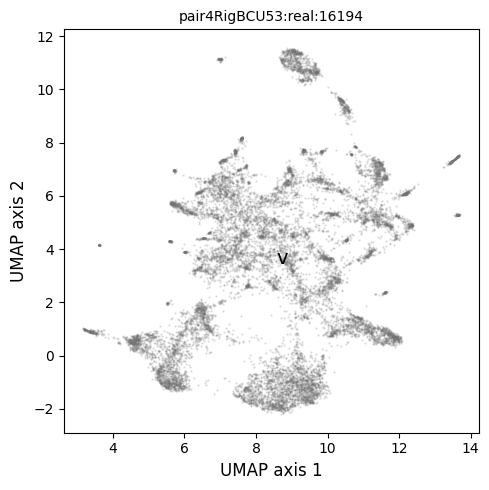

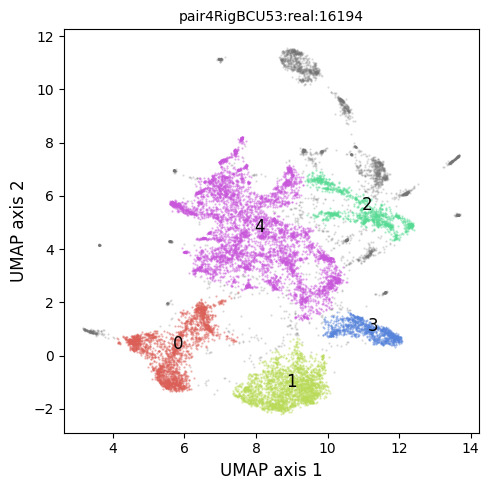

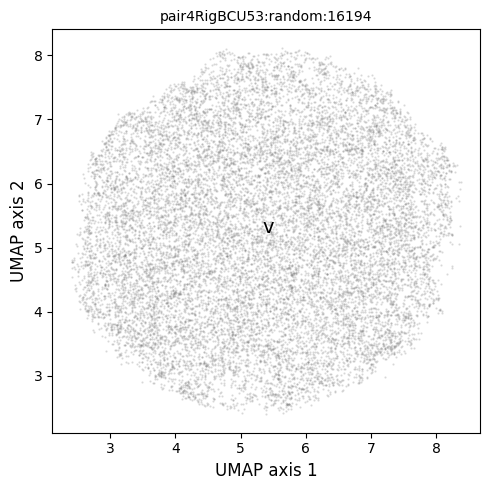

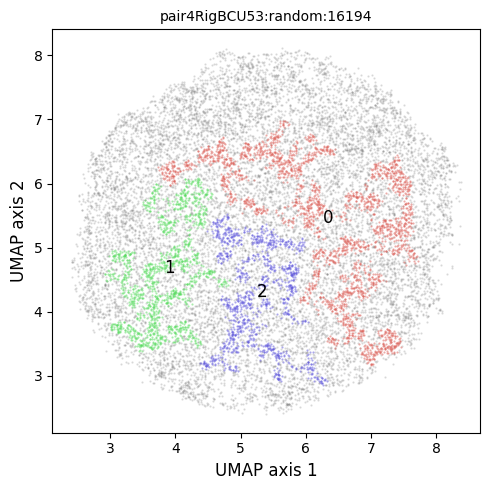

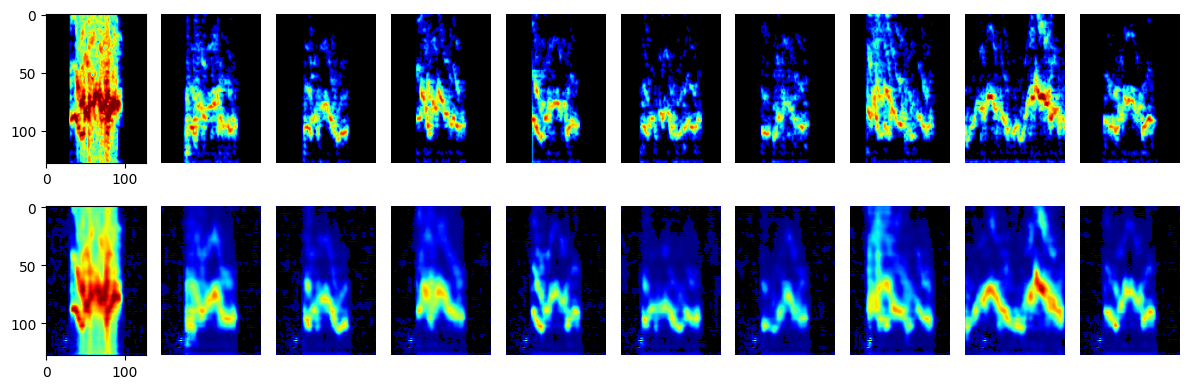

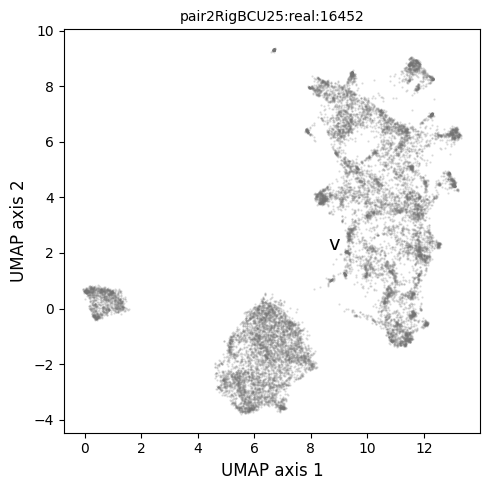

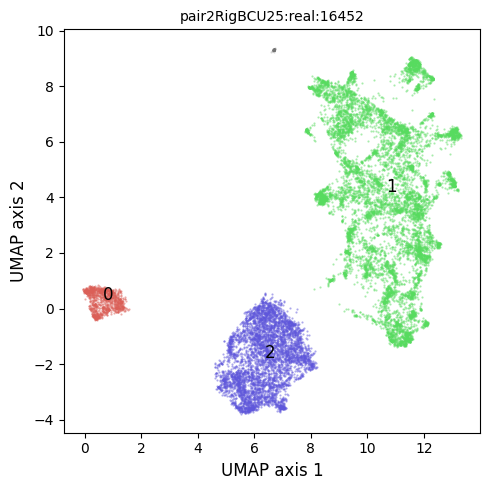

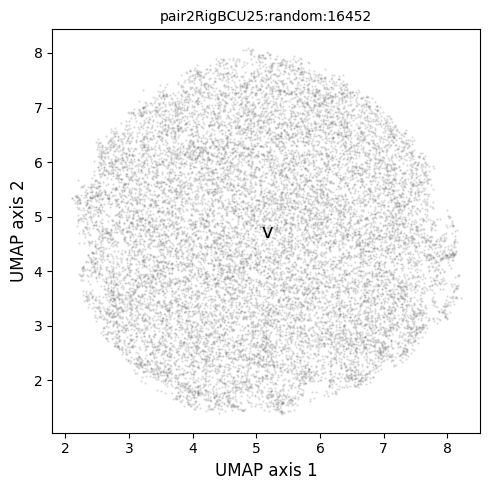

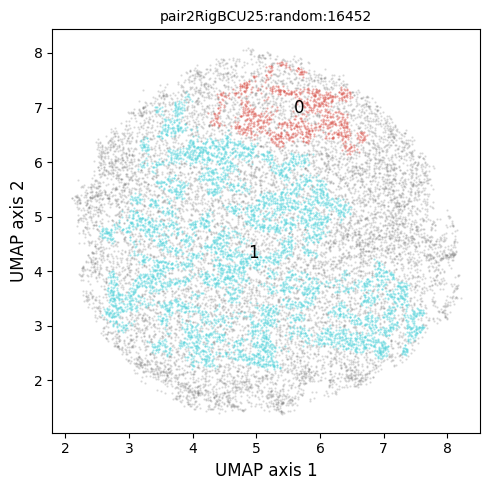

In [18]:
# loop through birds
for bi in range(1, len(birdIDs)):
    bd = birdIDs[bi]
    # loop through datasets
    for rn in run_names:
        fd_save = os.path.join(fd_data, bd, 'UMAPonVAE1', sylStr, rn)
        if not os.path.exists(fd_save):
            os.makedirs(fd_save)

        print(f'Processing for {bd} {rn}...')
        print(f'Save results to {fd_save}')
        ## load spectrograms and meta info
        fn_spec = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{rn}.h5')
        fn_info = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{rn}.info.csv')
        with h5py.File(fn_spec, 'r') as f:
            spec_win_all = f['spec_win_all'][:]  #

        info = pd.read_csv(fn_info, index_col=0)

        print(spec_win_all.shape, info.shape)

        ## train VAE network
        # create dataloader from h5 file
        train_data = vae_goffinet.SpecDataset(fn_spec)
        # set a random seed
        g = torch.Generator()
        g.manual_seed(42)
        train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, generator=g)  # set shuffle to true
        loaders = {'train':train_dataloader, 'test':train_dataloader}

        # init VAE model then train
        model = vae_goffinet.VAE(save_dir=fd_save)
        model.train_loop(loaders, epochs=51, test_freq=None, vis_freq=None, save_freq=10)

        # save model
        fn_model = os.path.join(fd_save, f'{bd}_checkpoint_final.tar')
        model.save_state(fn_model)

        ## Obtain latent representation
        train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)  # set shuffle to false to match the order in id_pd

        # loop through dataloader, obtain model latent space
        latent_m = np.zeros((info.shape[0], 32))
        latent_d = np.zeros((info.shape[0], 32))
        recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
        model.eval()
        count = 0
        for i, data in tqdm.tqdm(enumerate(train_dataloader)):
            data = data.to('cuda:0')
            with torch.no_grad():
                _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
                a = rec.shape[0]
                latent_m[count:(count+a),:] = mu
                latent_d[count:(count+a),:] = d
                recon[count:(count+a),:,:] = rec
                count += a

        # save the latent representations
        fn_latentM = os.path.join(fd_save, 'latentM.csv')
        np.savetxt(fn_latentM, latent_m, delimiter=',')
        fn_latentD = os.path.join(fd_save, 'latentD.csv')
        np.savetxt(fn_latentD, latent_d, delimiter=',')
        print(latent_m.shape)

        ## check recontruction accuracy (optional)
        # plot some random samples
        fig, ax = plt.subplots(2, 10, figsize=[12,4])
        random.seed(1118)
        random_i = random.sample(list(range(recon.shape[0])), 10)
        with h5py.File(fn_spec, 'r') as file:
            for ii in range(10):
                spec = train_data[random_i[ii],:,:].numpy()
                ax[0][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
                spec = recon[random_i[ii],:,:]
                ax[1][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
                if ii>0:
                    ax[0][ii].axis('off')
                    ax[1][ii].axis('off')
        plt.tight_layout()
        # save fig
        fn_fig = os.path.join(fd_save, 'reconstructed_spectrogram.pdf')
        fig.savefig(fn_fig)

        ### UMAP/HDBSCAN
        ## construct a mean and variance matched Gaussian dataset
        # estimated mean and variance
        mu = latent_m.mean(axis=0)                        # empirical mean  (shape: 32,)
        Sigma  = np.cov(latent_m, rowvar=False, ddof=1)
        # draw random samples
        rng = np.random.default_rng(seed=42)  
        latent_rd = rng.multivariate_normal(mean=mu, cov=Sigma, size=latent_m.shape[0], method='cholesky')
        latent_rd.shape

        # conduct UMAP/HDBSCAN on real and shuffled datasets
        ds = [latent_m, latent_rd]
        suffix = ['real', 'random']
        for di in range(len(ds)):
            d = ds[di]
            # add latent_m to the embedding data frame
            embed = info.copy()
            for ii in range(d.shape[1]):
                embed[f'vae{ii}'] = d[:,ii]

            ## run UMAP 
            print(param_umap)
            umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                          metric=param_umap['metric'], random_state=1118, verbose=True)
            res = umap_model.fit_transform(d)

            # add UMAP embedding to the dataframe
            for jj in range(res.shape[1]):
                embed[f'umap{jj+1}'] = res[:,jj]

            ## plot embedding
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
            for si, ss in enumerate(syl):
                embed_s = embed[embed['label']==ss]
                ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, c='#737373')
                # add syl label
                ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), ss, fontsize=14)
            ax.set_title(f'{bd}:{suffix[di]}:{embed.shape[0]}', fontsize=10)
            ax.set_xlabel('UMAP axis 1', fontsize=12)
            ax.set_ylabel('UMAP axis 2', fontsize=12)
            plt.tight_layout()
            # save fig
            fn_fig =os.path.join(fd_save, f'{bd}.{suffix[di]}.UMAPonVAE.embedding.pdf')
            fig.savefig(fn_fig)

            ## HDBSCAN clustering
            clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'])
            # clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
            clusterer.fit(res)
            embed['hdbscan_cluster'] = clusterer.labels_
            embed['hdbscan_prob'] = clusterer.probabilities_

            # save embedding and clustering 
            fn_embed = os.path.join(fd_save, f'{bd}.{suffix[di]}.UMAPonVAE.embedding.csv')
            embed.to_csv(fn_embed)

            # what's the fraction that's not clustered
            unc_f = embed[embed['hdbscan_cluster']==-1].shape[0] / embed.shape[0]
            print(f'The fraction that are not clustered: {unc_f:.4f}')
            num_c = max(embed['hdbscan_cluster']+1)
            print(f'Total number of clusters: {num_c}')

            # color calls according to hdbscan labels
            col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster'])+1)
            # plot embedding
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
            for hi in range(-1, max(embed['hdbscan_cluster'])+1):
                embed_s = embed[embed['hdbscan_cluster']==hi]
                if hi==-1:
                    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
                else:
                    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, color=col_long[hi])
                    # add syl label
                    ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
            ax.set_title(f'{bd}:{suffix[di]}:{embed.shape[0]}', fontsize=10)
            ax.set_xlabel('UMAP axis 1', fontsize=12)
            ax.set_ylabel('UMAP axis 2', fontsize=12)
            plt.tight_layout()
            # save fig
            fn_fig = os.path.join(fd_save, f'{bd}.{suffix[di]}.UMAPonVAE.HBBSCAN.pdf')
            fig.savefig(fn_fig)

            ## Quantify clustering tendency
            # in UMAP space
            hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
            print(f'Hopkins metric in UMAP: {hpk1:.4f}')
            # in VAE space
            hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
            print(f'Hopkins metric in VAE: {hpk2:.4f}')

            ## Quantify clustering quality with Silhoutte score
            # in UMAP space
            sil1 = silhouette_score(res, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
            print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
            # in VAE space
            sil2 = silhouette_score(latent_m, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
            print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

            # Calinski–Harabasz (CH) Index
            cah1 = calinski_harabasz_score(res, embed['hdbscan_cluster'])
            print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
            cah2 = calinski_harabasz_score(latent_m, embed['hdbscan_cluster'])
            print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

            # save data to the master data frame
            row = pd.DataFrame([{'birdID':bd, 'run_name':rn, 'type':suffix[di], 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                                 'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])
            metrics = pd.concat([metrics, row], ignore_index=True)

In [21]:
# save the metrics
fn_metric = os.path.join(fd_save, 'UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics

,birdID,run_name,type,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair5RigCCU29,spec_goffinet_nn_256_176,real,6,0.113124,"[0.15763438657619475, 0.318731627070003, 0.384...",0.985925,0.860745,0.368774,0.007379,13935.022315,894.482821,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
1,pair5RigCCU29,spec_goffinet_nn_256_176,random,3,0.740318,"[0.02890398845374216, 0.006391751167116018, 0....",0.865969,0.860745,-0.224358,-0.004454,820.762408,0.771342,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
2,pair4RigACU68,spec_goffinet_nn_256_176,real,6,0.188674,"[0.4607926898236672, 0.4307462790363003, 0.496...",0.983814,0.850167,0.361994,0.013354,18939.537783,1498.197714,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
3,pair4RigACU68,spec_goffinet_nn_256_176,random,3,0.532825,"[0.01719812137614779, 0.02522885907223679, 0.0...",0.871000,0.850167,-0.071310,-0.004043,3144.454228,1.311890,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
4,pair4RigBCU53,spec_goffinet_nn_256_176,real,5,0.203903,"[0.3834021988446942, 0.5671341512442932, 0.175...",0.969732,0.824799,0.308996,-0.001803,7289.893201,601.120722,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
5,pair4RigBCU53,spec_goffinet_nn_256_176,random,3,0.691738,"[0.0030399724023119157, 0.011110399410827757, ...",0.840919,0.824799,-0.170975,-0.005393,715.863985,0.833729,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
6,pair2RigBCU25,spec_goffinet_nn_256_176,real,3,0.005835,"[0.9287220427088437, 0.4155011546811405, 0.676...",0.984935,0.831036,0.450272,0.032453,14335.356019,864.109198,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
7,pair2RigBCU25,spec_goffinet_nn_256_176,random,2,0.582665,"[0.023273202824147264, 0.014123941903685952]",0.862415,0.831036,-0.077150,-0.000379,800.784934,0.968527,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


## 3. Plot summary metrics

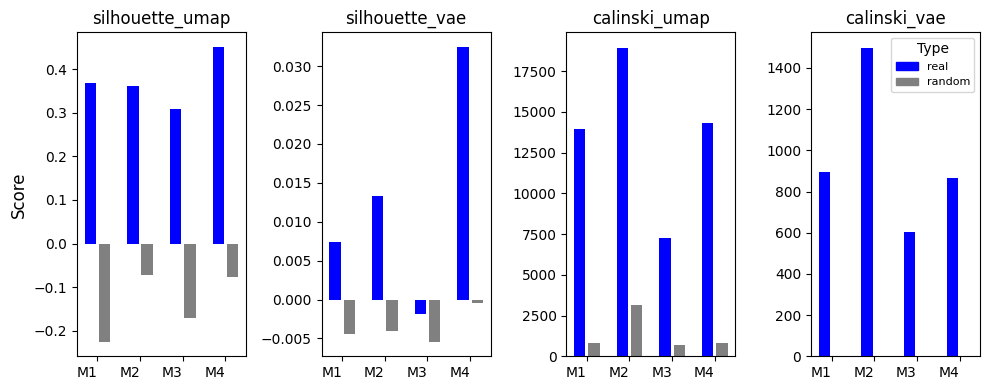

In [40]:
# Define color map and metrics to plot
colors = {'real': 'blue', 'random': 'grey'}
metrics_list = ['silhouette_umap','silhouette_vae', 'calinski_umap', 'calinski_vae']
types = ['real', 'random']
pretty_id = ['M1', 'M2', 'M3', 'M4']

# Prepare x locations with gaps
n_types = len(types)
x_ticks = []
x_labels = []
x = []

for i, bird in enumerate(birdIDs):
    for j, t in enumerate(types):
        x.append(i * (n_types + 1) + j)  # +1 introduces the extra spacing
        x_labels.append(bird if j == 0 else "")  # Only label once per bird
    x_ticks.append(i * (n_types + 1) + 0.5)  # center of the pair

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10, 4), sharex=True)

for ax, metric in zip(axes, metrics_list):
    for i, bird in enumerate(birdIDs):
        for j, t in enumerate(types):
            val = metrics.loc[(metrics['birdID'] == bird) & (metrics['type'] == t), metric]
            if not val.empty:
                ax.bar(i * (n_types + 1) + j, val.values[0], color=colors[t], width=0.8)

    ax.set_title(metric)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(pretty_id, ha='right')

axes[0].set_ylabel('Score', fontsize=12)
axes[3].legend(handles=[plt.Rectangle((0, 0), 1, 1, color=colors[t]) for t in types],
               labels=types, title='Type', loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()
fn_fig = os.path.join(fd_save, 'UMAPonVAE.metrics.pdf')
fig.savefig(fn_fig)

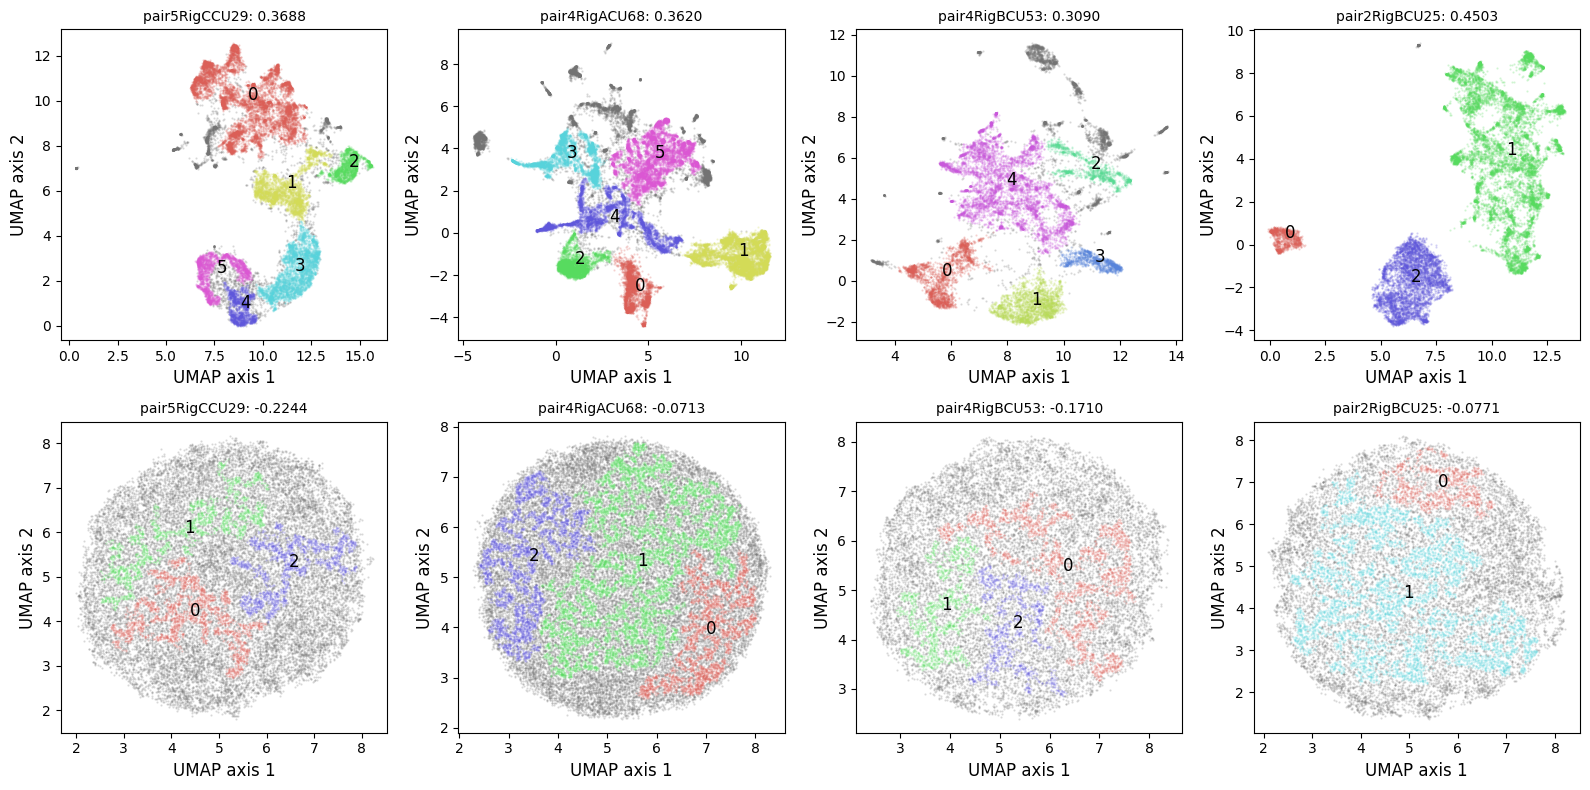

In [55]:
# Combine the HDBSCAN clustering plot
# bi = 0
# one figure for all birds
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[16, 8])
for bi in range(len(birdIDs)):
    bd = birdIDs[bi]
    rn = run_names[0]
    fd_save = os.path.join(fd_data, bd, 'UMAPonVAE1', sylStr, rn)
    # real data at top, shuffled data at bottom 
    for di in range(len(suffix)):
        fn_embed = os.path.join(fd_save, f'{bd}.{suffix[di]}.UMAPonVAE.embedding.csv')
        embed = pd.read_csv(fn_embed, index_col=0)
        ax = axes[di][bi]
        # color calls according to hdbscan labels
        col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster'])+1)
        # plot embedding
        for hi in range(-1, max(embed['hdbscan_cluster'])+1):
            embed_s = embed[embed['hdbscan_cluster']==hi]
            if hi==-1:
                ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
            else:
                ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color=col_long[hi])
                # add syl label
                ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
        sil = metrics.loc[(metrics['birdID'] == bd) & (metrics['type'] == suffix[di]), 'silhouette_umap'].iloc[0]
        ax.set_title(f'{bd}: {sil:.4f}', fontsize=10)
        ax.set_xlabel('UMAP axis 1', fontsize=12)
        ax.set_ylabel('UMAP axis 2', fontsize=12)
    plt.tight_layout()
    # save plot
    fn_fig = os.path.join(fd_save, f'HDBSCANcomb.pdf')
    fig.savefig(fn_fig)

## plot the cluster persistence

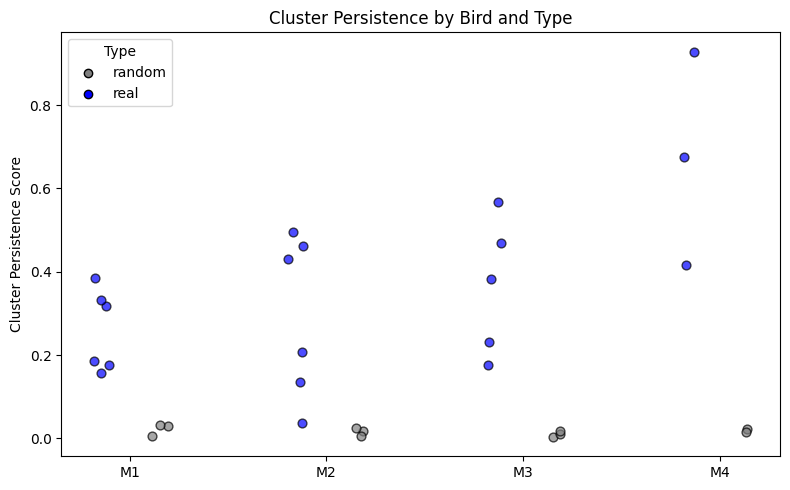

In [59]:
# Assume metrics is your DataFrame
colors = {'real': 'blue', 'random': 'grey'}
pretty_ids = ['M1', 'M2', 'M3', 'M4']
type_order = ['random', 'real']
jitter_strength = 0.1
bird_spacing = 2  # distance between birdID groups
type_offset = {'real': -0.3, 'random': 0.3}

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 5))

for i, bird in enumerate(birdIDs):
    for t in type_order:
        df_sub = metrics[(metrics['birdID'] == bird) & (metrics['type'] == t)]
        if not df_sub.empty:
            scores = df_sub.iloc[0]['cluster_persist']
            x_center = i * bird_spacing + type_offset[t]
            x_vals = x_center + np.random.uniform(-jitter_strength, jitter_strength, size=len(scores))
            ax.scatter(x_vals, scores, color=colors[t], alpha=0.7, edgecolor='black', s=40)

# Axis formatting
ax.set_xticks([i * bird_spacing for i in range(len(birdIDs))])
ax.set_xticklabels(pretty_ids)
ax.set_ylabel('Cluster Persistence Score')
ax.set_title('Cluster Persistence by Bird and Type')

# Legend
for t in type_order:
    ax.scatter([], [], color=colors[t], edgecolor='black', label=t)
ax.legend(title='Type')

plt.tight_layout()
plt.show()
